# Analysis of trpcage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from itertools import combinations

In [2]:
def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

In [3]:
from scipy import constants

def free_energy(x):
    kb = constants.k
    T = 300
    return (-1) * kb * T * np.log(x)

In [4]:
force_field = "c36m"

Number of native contacts 121


/tmp/ipykernel_1833938/3390925610.py:48: RuntimeWarning: overflow encountered in exp
  q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)


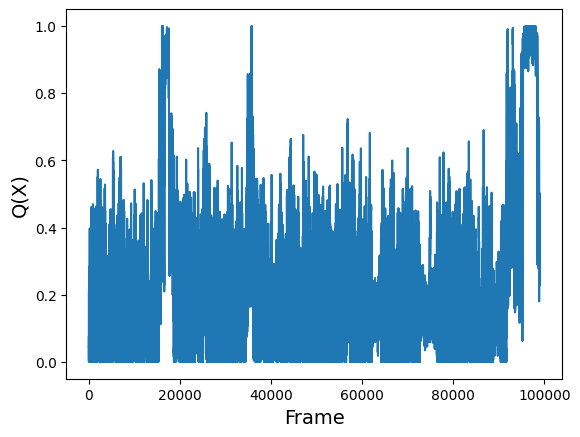

In [5]:
traj = md.load(f"../{force_field}/all.1ns.xtc", top=f"../{force_field}/native.pdb")
native = md.load_pdb(f"../{force_field}/native.pdb")

q = best_hummer_q(traj, native)

plt.plot(q)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()

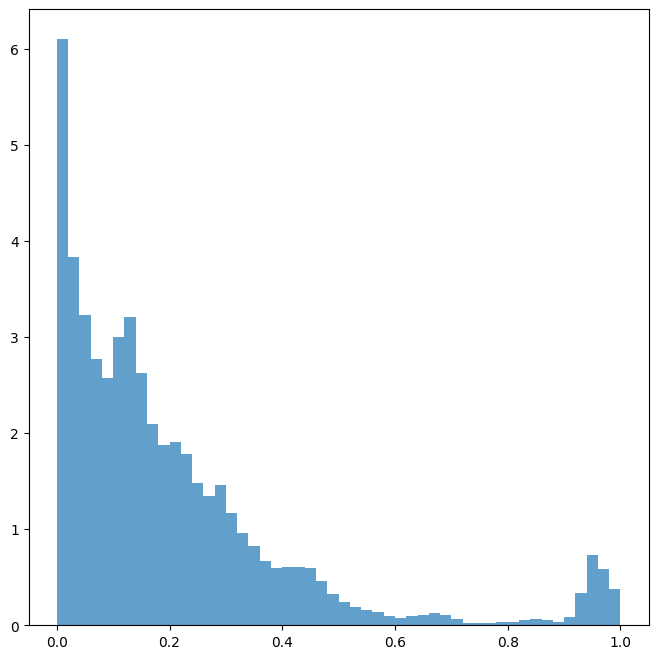

In [6]:
plt.figure(figsize=(8,8))
plt.hist(q, bins=50, alpha=0.7, histtype="stepfilled", density=True)
plt.show()

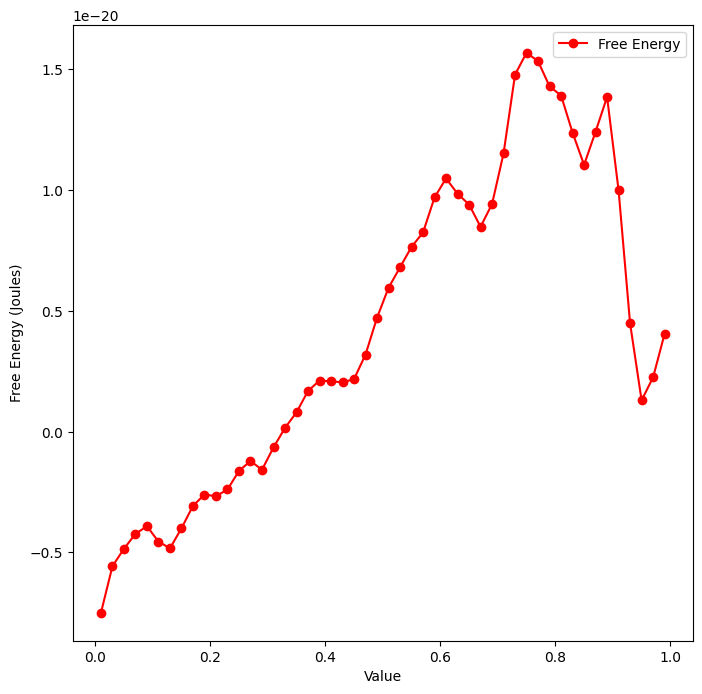

In [7]:
counts, bin_edges = np.histogram(q, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
free_energy_values = free_energy(counts)

plt.figure(figsize=(8, 8))
plt.plot(bin_centers, free_energy_values, label='Free Energy', color='red', marker='o')
plt.xlabel('Value')
plt.ylabel('Free Energy (Joules)')
plt.legend()
plt.show()

### Radius of gyration

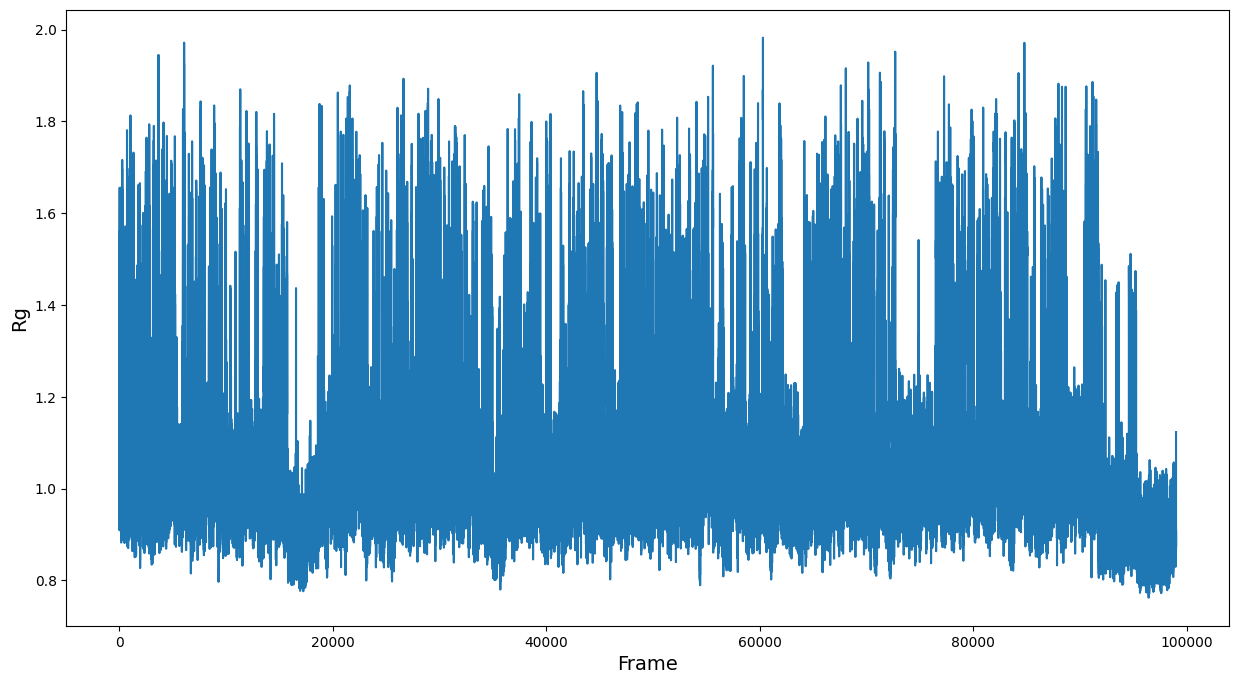

In [8]:
# Radius of gyration

rg = md.compute_rg(traj)
plt.figure(figsize=(15,8))
plt.plot(rg)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Rg', fontsize=14)
plt.show()

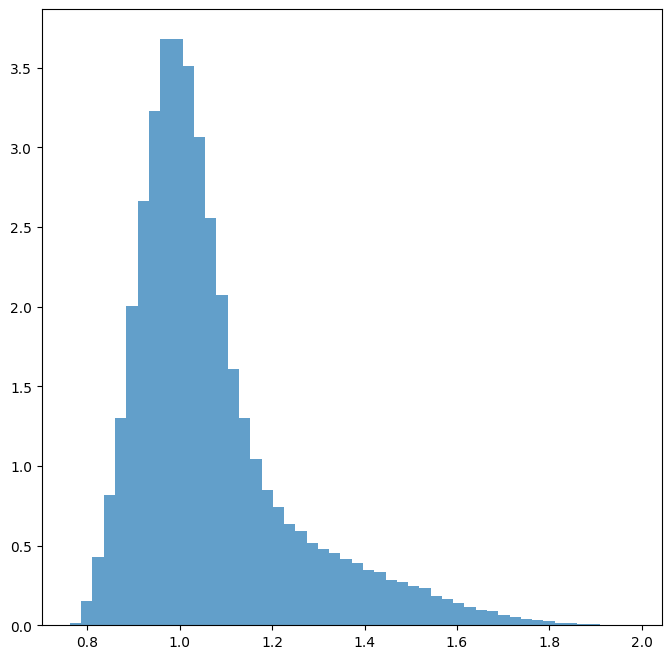

In [9]:
plt.figure(figsize=(8,8))
plt.hist(rg, bins=50, alpha=0.7, histtype="stepfilled", density=True)
plt.show()

### Free energy

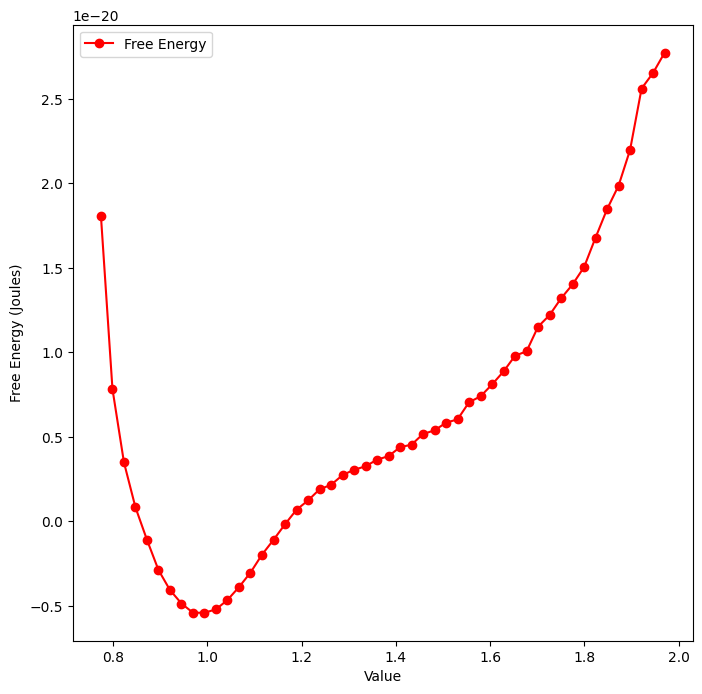

In [10]:
counts, bin_edges = np.histogram(rg, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
free_energy_values = free_energy(counts)

plt.figure(figsize=(8, 8))
# plt.hist(rg, bins=50, alpha=0.7, histtype="stepfilled", density=True, label='Probability Density')
plt.plot(bin_centers, free_energy_values, label='Free Energy', color='red', marker='o')
plt.xlabel('Value')
plt.ylabel('Free Energy (Joules)')
plt.legend()
plt.show()

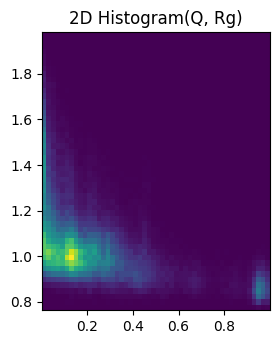

In [12]:
H, xedges, yedges = np.histogram2d(q, rg, bins=50)
H = H.T

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(132, title='2D Histogram(Q, Rg)',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

/tmp/ipykernel_1833938/2178444992.py:2: RuntimeWarning: divide by zero encountered in log
  D = -0.5962*np.log(D)      # conversion to free energy in kcal/mol


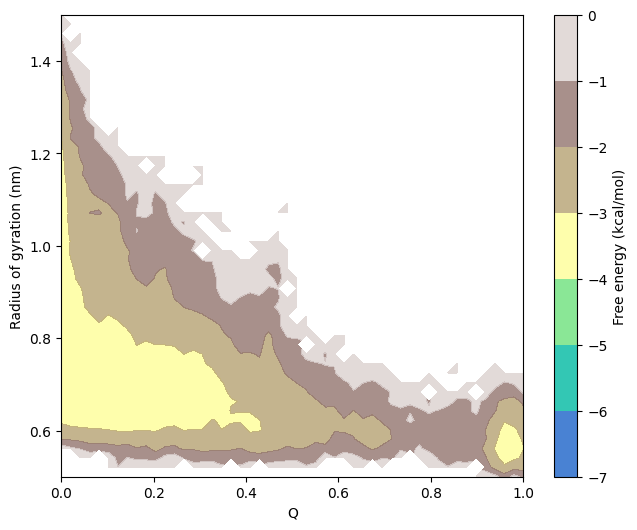

In [13]:
D = H
D = -0.5962*np.log(D)      # conversion to free energy in kcal/mol

x = np.linspace(0, 1, 50)
y = np.linspace(0.5, 1.5, 50)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(8,6))
plt.axes(aspect='equal')
plt.axis([0,1,0.5,1.5])
plt.xlabel('Q')
plt.ylabel('Radius of gyration (nm)')

cmap = plt.get_cmap('terrain')
CS = plt.contourf(X, Y, D, cmap=cmap, alpha=0.8, levels=[-7,-6,-5,-4,-3,-2,-1,0]) 
plt.colorbar(CS, boundaries=[-7,-6,-5,-4,-3,-2,-1,0], label='Free energy (kcal/mol)')

plt.show()

# plt.savefig('output.png', transparent=True, dpi=600)